In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = "drive/My Drive/ABRO/"
!ls "drive/My Drive/ABRO/ADNI/"

from IPython.display import clear_output
# !cd "drive/My Drive/ABRO/Atlas/" && unrar e MASKS_MNI2mm.rar

Mounted at /content/drive
AD  CN


In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

######################
###Model Parameters###

alpha = 0.025
betha = 1 - alpha

width = 80
height = 80
depth = 80
nLabel = 2
#####################

fRange1 = slice(6,86)
fRange2 = slice(16,96)
fRange3 = slice(6,86)

In [3]:
def norm(A):
       return A#(A-np.amin(A))/(np.amax(A)-np.amin(A))

_data = []
_labels = []
G=glob.glob(data_path+'ADNI/AD/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(1)


G=glob.glob(data_path+'ADNI/CN/*.gz')
for _g in G:
    n1_img = nib.load(_g)
    print(_g)
    tmp=np.array(n1_img.get_fdata())
    tmp=tmp[fRange1,fRange2,fRange3]
    _data.append(norm(tmp))
    _labels.append(0)

#################################
###########Loading Masks#########
G =sorted(glob.glob(data_path+'Atlas/*.nii'))
Bmasks = np.zeros((width, height, depth, len(G)), dtype=bool)
Template = np.zeros((width, height, depth), dtype=bool)
idx = 0
for g in G:
    n1_img = nib.load(g)
    tmp = np.array(n1_img.get_fdata())
    tmp = tmp[fRange1, fRange2, fRange3] > 0
    Bmasks[..., idx] = tmp
    idx += 1
    Template = np.logical_or(Template, tmp)    
Template = np.logical_not(Template)
#################################

clear_output()
_data = np.array(_data, dtype=np.float32)#[...,np.newaxis]
_labels = np.array(_labels)

print('_data.shape=>', _data.shape)
print('_labels.shape=>', _labels.shape)

_data.shape=> (145, 80, 80, 80)
_labels.shape=> (145,)


In [4]:
from sklearn.model_selection import train_test_split 
# from tensorflow.keras.utils import to_categorical

# oh_labels = to_categorical(_labels)

x_train, x_test, y_train, y_test  = train_test_split(_data, _labels,
                              train_size=.8,random_state=123,shuffle=True)

del _data
del _labels
print('x_train.shape=>', x_train.shape)
print('y_train.shape=>', y_train.shape)
print('x_test.shape=>', x_test.shape)
print('y_test.shape=>', y_test.shape)



x_train.shape=> (116, 80, 80, 80)
y_train.shape=> (116,)
x_test.shape=> (29, 80, 80, 80)
y_test.shape=> (29,)


In [5]:
# def get_model(width=80, height=80, depth=80):
#     """Build a 3D convolutional neural network model."""

#     inputs = keras.Input((width, height, depth, 1))
#     x = (inputs)

#     x = layers.Conv3D(filters=8, kernel_size=5, activation="relu", padding="same")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding="same")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
#     x = layers.MaxPool3D(pool_size=2)(x)
#     x = layers.BatchNormalization()(x)

#     # x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
#     # x = layers.MaxPool3D(pool_size=2)(x)
#     # x = layers.BatchNormalization()(x)

#     # x = layers.GlobalAveragePooling3D()(x)
#     x = layers.Flatten()(x)

#     x = layers.Dense(units=512, activation="sigmoid")(x)
#     x = layers.Dropout(0.05)(x)

#     outputs = layers.Dense(units=1, activation="sigmoid")(x)

#     # Define the model.
#     model = keras.Model(inputs, outputs, name="3dcnn")
#     return model


# # Build model.
# model = get_model(width=80, height=80, depth=80)
# # model.summary()

In [6]:
def get_model(width=80, height=80, depth=80):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    x = (inputs)

    x = layers.Conv3D(filters=8, kernel_size=5, activation="relu", padding="same", name="conv3d_1")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=16, kernel_size=3, activation="relu", padding="same", name="conv3d_2")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu", padding="same", name="conv3d_3")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=512, activation="sigmoid")(x)
    x = layers.Dropout(0.05)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=80, height=80, depth=80)
# model.summary()

In [7]:
# Load best weights.
model.load_weights(data_path+"chkp/3d_MRI_classification_1.h5")
prediction=[]
_bs = 16
for i in range(0,x_test.shape[0],_bs):
    XTD = x_test[i:min(i+_bs,x_test.shape[0]),...]
    XTD = XTD[...,np.newaxis]
    _pred = model.predict(XTD)[:,0]
    prediction.extend(_pred.tolist())
prediction = np.array(prediction)
# for _p in range(len(prediction)):
#     scores = np.array([1 - prediction[_p], prediction[_p]])
#     class_names = ["normal", "abnormal"]
#     print('Real label is =>',class_names[y_test[_p]])
#     score = scores.max()
#     name = class_names[scores.argmax()]
#     print(
#         "This model is %.2f percent confident that MRI scan is %s"
#         % ((score), name)
#     )
#     print('<##>'*10)


y_pred = np.where(prediction<0.5,0,1)
y_true = y_test

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
Accuracy = (tp + tn) / (tp + fp + fn + tn)
ACC = Accuracy.sum()
print('Confusion matrix(test):\n{}'.format(confusion_matrix(y_true, y_pred)))
print("Accuracy", ACC)
Precision = tp/(tp+fp)
print("Precision", Precision)
Recall = tp/(tp+fn)
print("Recall",Recall)

Confusion matrix(test):
[[12  0]
 [ 2 15]]
Accuracy 0.9310344827586207
Precision 1.0
Recall 0.8823529411764706


In [8]:
Conv_layer = [model.get_layer('conv3d_1').output,
              model.get_layer('conv3d_2').output,
              model.get_layer('conv3d_3').output]
new_model = keras.Model(inputs=model.input,outputs=Conv_layer,name='3dcnn4vis')
new_model.summary()

xtd = x_train[5]
xtd = xtd[np.newaxis,...,np.newaxis]
activation_maps = new_model.predict(xtd)#[0]

Model: "3dcnn4vis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 80, 1)]   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 80, 80, 80, 8)     1008      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 40, 40, 40, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 40, 8)     32        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 40, 40, 40, 16)    3472      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 20, 20, 20, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 20, 16)    64

conv3d_1 activation map


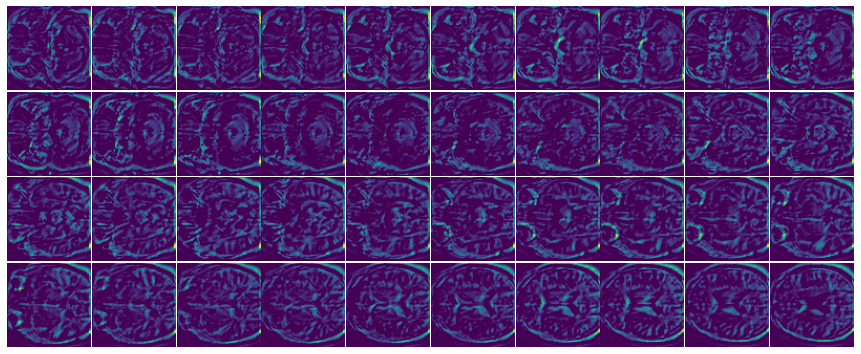

conv3d_2 activation map


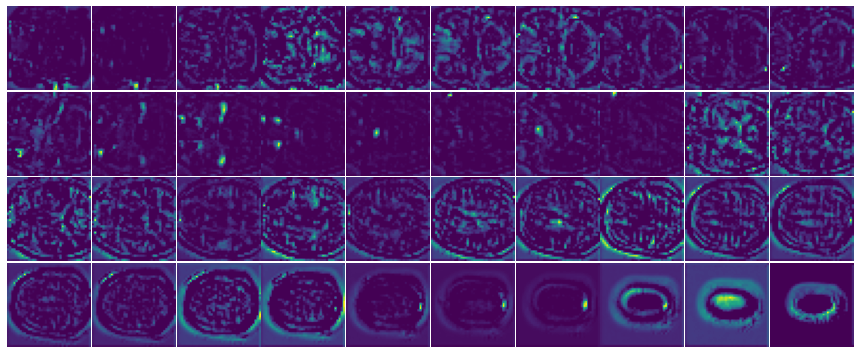

conv3d_3 activation map


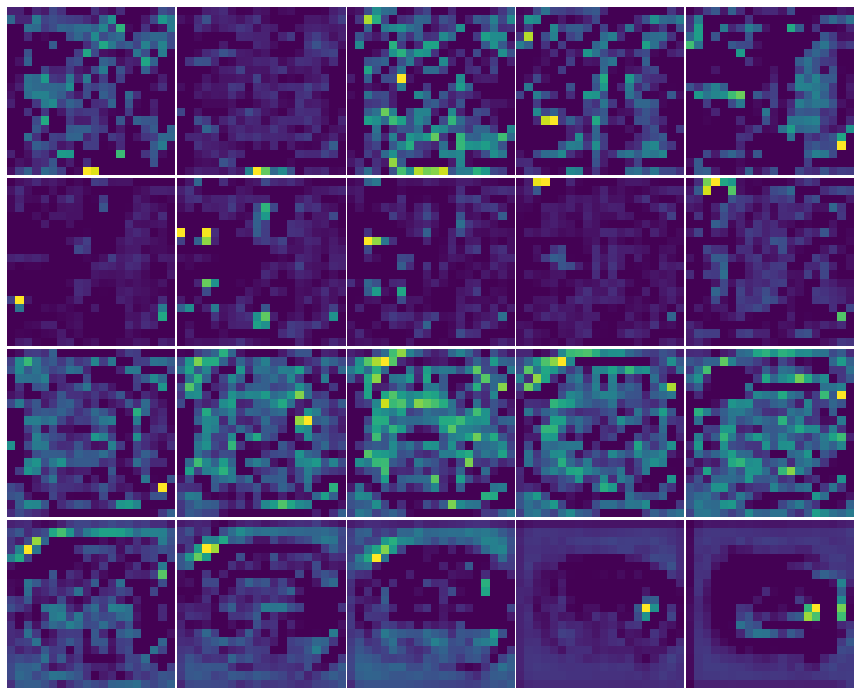

In [9]:

def plot_slices(num_rows, num_columns, width, height, data,cmap=None):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    if len(data.shape)==3:
        data = np.transpose(data)
        data = np.reshape(data, (num_rows, num_columns, width, height))
    else:
        data = np.transpose(data,[3,1,0,2])
        data = np.reshape(data, (num_rows, num_columns, width, height, 3))

    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            t_data = data[i][j]     
            axarr[i, j].imshow(t_data*255, cmap=cmap)
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0.01, hspace=0, left=0.02, right=1, bottom=0.01, top=1)
    plt.show()




print('conv3d_1 activation map')
plot_slices(4, 10, 80, 80, activation_maps[0][0,:, :, 10:50,5])
print('conv3d_2 activation map')
plot_slices(4, 10, 40, 40, activation_maps[1][0,:, :, :,13])
print('conv3d_3 activation map')
plot_slices(4, 5, 20, 20, activation_maps[2][0,:, :, :,13])



In [10]:
bls = 20
bls = int(bls/2)
stp = 3
heatmap = np.zeros_like(xtd, dtype=np.float32)[0,...,0]
for w in range(0,width,stp):
    miw = max(0,w-bls)
    maw = min(width,w+bls)
    for h in range(0,height,stp):
        mih = max(0,h-bls)
        mah = min(height,h+bls)      
        for d in range(0,depth,stp):
            mid = max(0,d-bls)
            mad = min(depth,d+bls)          
            new_inp = xtd.copy()
            new_inp[0, miw:maw, mih:mah, mid:mad, 0] = 0
            _pred = model.predict(new_inp)[0,0]
            heatmap[w:w+stp,h:h+stp,d:d+stp] = _pred
            print('w:',w,'h:',h,'d:',d,'pred:',_pred)


np.save(data_path+'Heatmap', heatmap)
clear_output()

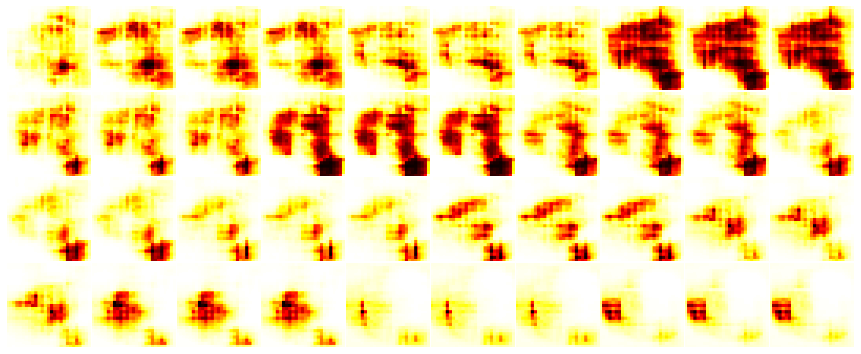

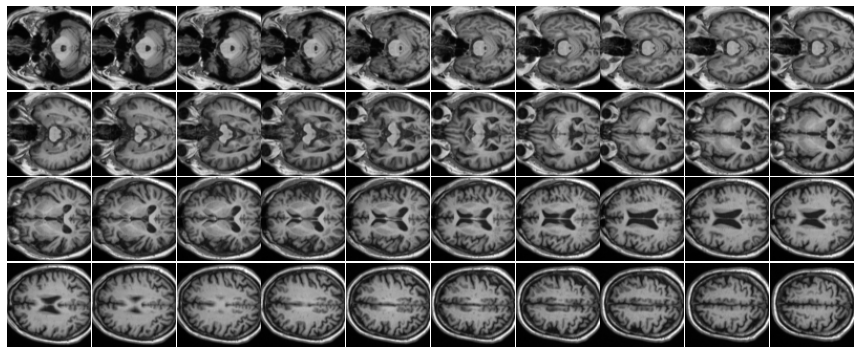

In [21]:
heatmap = np.load(data_path+'Heatmap.npy')
plot_slices(4, 10, 80, 80, 1-heatmap[:, :, 20:60],cmap='hot')
plot_slices(4, 10, 80, 80, xtd[0,:, :, 20:60,0],cmap='gray')
# heatmap[0,0,0]

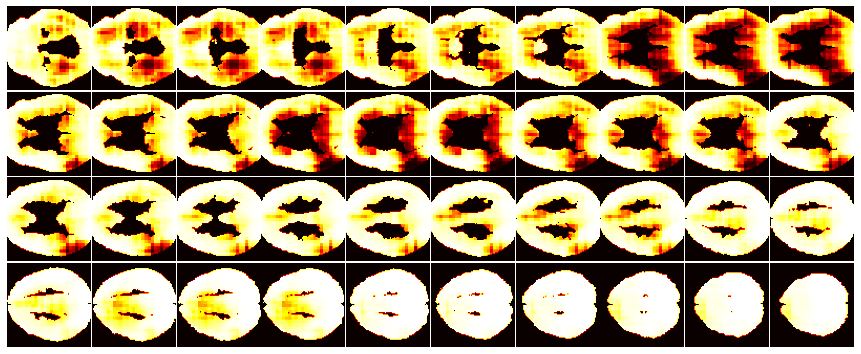

In [22]:
nh = 1-heatmap.copy()
Temp = np.logical_not(Template)#xtd[0,...,0]>60#
# nh[nh<=0.5]=1
# nh = (nh-0.5)*2
# nh[nh<0]=.0
nh = np.multiply((nh),Temp)
plot_slices(4, 10, 80, 80, nh[:, :, 20:60],cmap='hot')

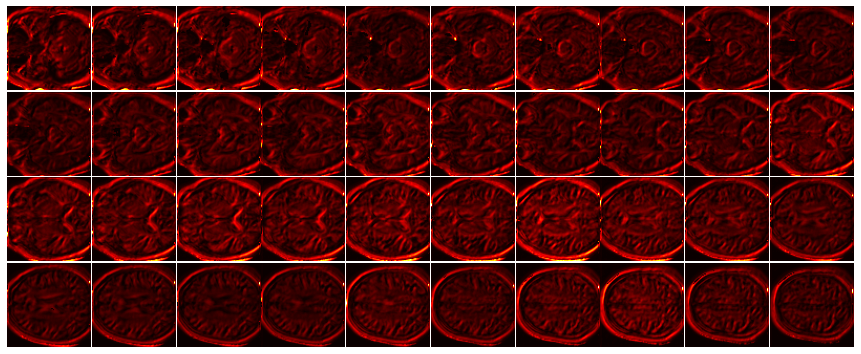

In [23]:
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

last_conv_layer_name = "conv3d_1"
classifier_layer_names = []
meet_last = False
for layer_name in model.layers:
    ln=layer_name.name
    # print(ln)
    if  ln == last_conv_layer_name:
        meet_last = True
        continue 
    if not meet_last:
        continue
    classifier_layer_names.append(ln)


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        # print(preds.shape)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2,3))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



heatmap = make_gradcam_heatmap(xtd, model, last_conv_layer_name, classifier_layer_names)

plot_slices(4, 10, 80, 80, heatmap[:, :, 20:60],cmap='hot')